In [ ]:
import pandas as pd
import scipy.io
import torch
import numpy as np
import mne
import matplotlib as plt
import pyedflib
from torch.utils.data import TensorDataset, DataLoader
from eeg_transformer import EEGTransformerModel, add_noise
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict

sample_frequency = 128

mat_data = scipy.io.loadmat("./dataset.mat")
# Extract only the relevant variables (excluding metadata)
variables = {key: mat_data[key] for key in mat_data if not key.startswith('__')}

# Inspect shapes
for key, value in variables.items():
    print(f"{key}: shape {value.shape}, type {type(value)}")

print(variables.keys())

inputs = torch.tensor(variables["EEGsample"]).permute(0, 2, 1) #  (batch_size, time_samples, channels)
sub_idxs = torch.tensor(variables["subindex"].squeeze())
targets = torch.tensor(variables["substate"].squeeze())

def preprocess_eeg(inputs, sub_idxs, sfreq=128, notch_freq=50):
    """
    Preprocess EEG data: notch filter and normalize per subject.

    Args:
        inputs (torch.Tensor): EEG data of shape (N, T, C)
        sub_idxs (torch.Tensor): Subject indices of shape (N,)
        sfreq (int): Sampling frequency in Hz
        notch_freq (float): Frequency to notch filter (e.g., 50 or 60 Hz)
    
    Returns:
        torch.Tensor: Preprocessed EEG data of shape (N, T, C)
    """
    assert inputs.ndim == 3, "Input tensor must be 3D (trials, time, channels)"
    
    # Convert to (N, C, T) for MNE
    inputs = inputs.permute(0, 2, 1)  # (N, C, T)
    N, C, T = inputs.shape

    # Notch filter each trial
    filtered = []
    for i in range(N):
        data_np = inputs[i].numpy()
        info = mne.create_info(ch_names=[f'ch{j}' for j in range(C)], sfreq=sfreq, ch_types='eeg')
        raw = mne.io.RawArray(data_np, info, verbose=False)
        raw.notch_filter(freqs=[notch_freq], method="iir", verbose=False)
        filtered_data = raw.get_data()
        filtered.append(torch.tensor(filtered_data))

    filtered = torch.stack(filtered)  # (N, C, T)

    # Normalize per subject (z-score per subject over all trials)
    normalized = torch.zeros_like(filtered)
    subject_data = defaultdict(list)

    for i in range(N):
        subject = int(sub_idxs[i].item())
        subject_data[subject].append(filtered[i])

    for subject, trials in subject_data.items():
        trials_tensor = torch.stack(trials)  # (n_trials, C, T)
        mean = trials_tensor.mean(dim=(0, 2), keepdim=True)
        std = trials_tensor.std(dim=(0, 2), keepdim=True)
        norm_trials = (trials_tensor - mean) / (std + 1e-6)

        for i, trial in zip(torch.where(sub_idxs == subject)[0], norm_trials):
            normalized[i] = trial

    # Return shape to (N, T, C)
    return normalized.permute(0, 2, 1).float()

inputs = preprocess_eeg(inputs, sub_idxs, sample_frequency, notch_freq=50) # Singapore powerline frequency is 50hz

print("Unique participant indices:", torch.unique(sub_idxs))

def create_fold(test_participant_idx, batch_size):
    train_mask = sub_idxs != test_participant_idx
    train_inputs = inputs[train_mask]
    train_targets = targets[train_mask]

    test_mask = sub_idxs == test_participant_idx
    test_inputs = inputs[test_mask]
    test_targets = targets[test_mask]

    train_dataset = TensorDataset(train_inputs, train_targets)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(test_inputs, test_targets)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

def train(model, lr, epochs, train_loader, test_loader):
    ce_loss = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
    optim = torch.optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(epochs):
        print(f"Epoch: {epoch}")
        model.train()
        train_loss = 0.0
        i = 0
        for batch_inputs, batch_targets in train_loader:
            outputs = model(add_noise(batch_inputs.to("cuda")))
            loss = ce_loss(outputs, batch_targets.to("cuda"))
            model.zero_grad()
            loss.backward()
            optim.step()
            train_loss += loss.detach().item()
            i += 1
            print(f"\r{i} Loss: {(train_loss / i):.4f}", end="", flush=True)
        print("\r", end="", flush=True)
        print(f"Train Loss: {train_loss / i}")
        
        model.eval()
        test_loss = 0.0
        i = 0
        with torch.no_grad():
            for batch_inputs, batch_targets in test_loader:
                outputs = model(batch_inputs.to("cuda"))
                loss = ce_loss(outputs, batch_targets.to("cuda"))
                test_loss += loss.detach().item()
                i += 1
        print(f"Test Loss: {test_loss / i}")

    all_preds = []
    all_labels = []

    i = 0
    test_loss = 0.0
    with torch.no_grad():
        for batch_inputs, batch_targets in test_loader:
            outputs = model(batch_inputs.to("cuda"))
            loss = ce_loss(outputs, batch_targets.to("cuda"))
            test_loss += loss.item()
            i+=1

            # Get predicted class (logits → class)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            labels = batch_targets.numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')

    print(f"Test Loss: {test_loss / i:.4f}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    return {"test_loss": (test_loss / i), "accuracy":accuracy, "precision":precision, "recall":recall, "f1":f1} 

batch_size = 64
folds = [create_fold(i, batch_size) for i in range(1, 11)]

#best params
epochs = 18
channels = 30
class_count = 2
dim     = 32
heads   = 8
layers  = 4
maxlen  = 384

lr = 1e-4


EEGsample: shape (2022, 30, 384), type <class 'numpy.ndarray'>
subindex: shape (2022, 1), type <class 'numpy.ndarray'>
substate: shape (2022, 1), type <class 'numpy.ndarray'>
dict_keys(['EEGsample', 'subindex', 'substate'])
Unique participant indices: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=torch.uint8)


Epoch: 0
Train Loss: 0.6388383774921812
Test Loss: 0.5125001966953278
Epoch: 1
Train Loss: 0.553630360241594
Test Loss: 0.488243301709493
Epoch: 2
Train Loss: 0.5159044019107161
Test Loss: 0.6054552296797434
Epoch: 3
Train Loss: 0.5228340677146254
Test Loss: 0.5184105833371481
Epoch: 4
Train Loss: 0.5052280806261917
Test Loss: 0.47099987665812176
Epoch: 5
Train Loss: 0.4779558140656044
Test Loss: 0.4936703046162923
Epoch: 6
Train Loss: 0.46243317271101064
Test Loss: 0.469743937253952
Epoch: 7
Train Loss: 0.4654941589667879
Test Loss: 0.46238333980242413
Epoch: 8
Train Loss: 0.469072884526746
Test Loss: 0.49546382824579877
Epoch: 9
Train Loss: 0.46778349938063785
Test Loss: 0.45962456862131756
Epoch: 10
Train Loss: 0.4501405019184639
Test Loss: 0.45816856622695923
Epoch: 11
Train Loss: 0.44620954271020563
Test Loss: 0.5262361069520315
Epoch: 12
Train Loss: 0.42286934420980254
Test Loss: 0.5236025452613831
Epoch: 13
Train Loss: 0.42309648106838094
Test Loss: 0.47878287235895794
Epoch: 14

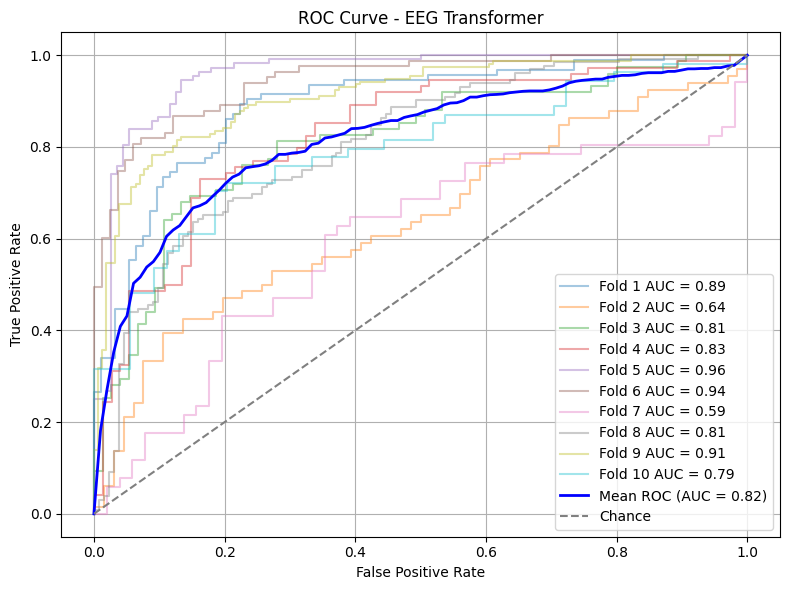

In [3]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def get_probs_and_labels(model, test_loader):
    all_probs = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for batch_inputs, batch_targets in test_loader:
            outputs = model(batch_inputs.to("cuda"))
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of class 1
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(batch_targets.cpu().numpy())
    return np.array(all_probs), np.array(all_labels)

# ROC AUC Plotting
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(8, 6))

for i, (train_loader, test_loader) in enumerate(folds):
    model = EEGTransformerModel(channels, class_count, dim, heads, layers, maxlen)
    model = model.to("cuda")
    train(model, lr, epochs, train_loader, test_loader)

    probs, labels = get_probs_and_labels(model, test_loader)
    fpr, tpr, _ = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

    plt.plot(fpr, tpr, lw=1.5, alpha=0.4, label=f"Fold {i+1} AUC = {roc_auc:.2f}")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='blue', lw=2, label=f"Mean ROC (AUC = {mean_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Chance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - EEG Transformer")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()